# Analysis of alphafold structure prediction

In this notebook the performance of alphafold predictions will be analysed. This will mainly focus on the accompanied plldt score that Alphafold will give for each structure it predicts. It will also include important statistics for alphafold predictions such as MSA deapth and coverage.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from helper import atom2res

In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## plddt analysis
This section show the statistics of the plddt score from alphafold. The plddt score has four accepted intervals.  
> **Very high (pLDDT > 90)** <br />
> **Confident (90 > pLDDT > 70)** <br />
> **Low (70 > pLDDT > 50)** <br />
> **Very low (pLDDT < 50)** 

In [150]:
files_plddt=[f"results/plddt/plddt_ranked_{idx}.csv" for idx in range(5)]

dfs = []
for idx, file in enumerate(files_plddt):
    tmp_df=pd.read_csv(file)
    tmp_df["model"]=[f"ranked_{idx}" for _ in range(tmp_df.shape[0])]
    dfs.append(tmp_df)
df=pd.concat(dfs)

df["plddt_res"] = df.apply(lambda x: atom2res(x.plddt, x.aa_pos), axis=1)

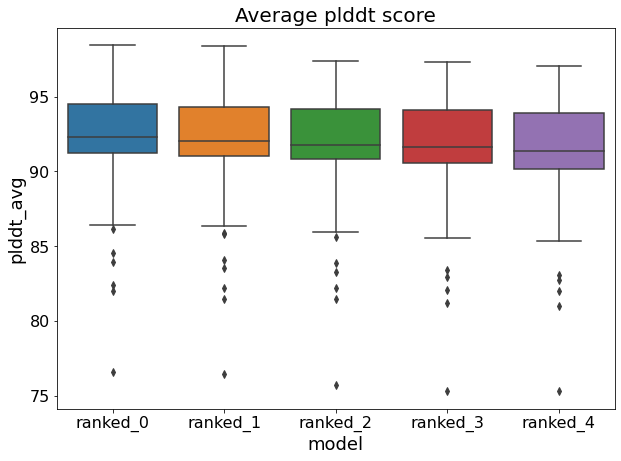

In [162]:
plt.figure(figsize=[10,7])
sns.boxplot(data=df, x="model", y="plddt_avg")
plt.title("Average plddt score")
plt.show()

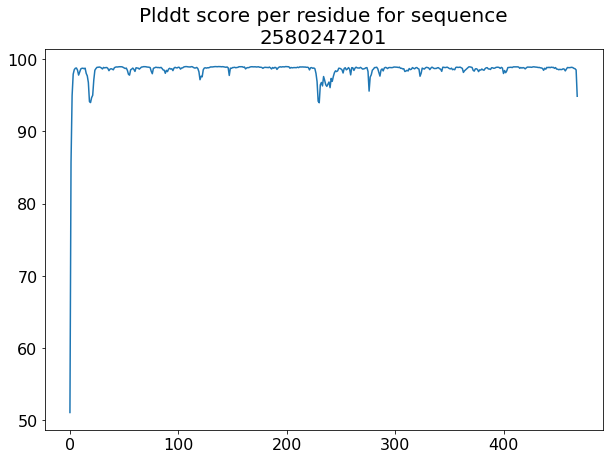

In [164]:
df_tmp = df[df["plddt_avg"] == df["plddt_avg"].max()]
id_ = df_tmp["ID"].values[0].split("_")[0]
df_tmp = df_tmp["plddt_res"].values[0]
#print(df_tmp[-100000:])
li = [float(rec) for rec in df_tmp if rec != ""]


y=np.array(li)
x=np.arange(y.size)
plt.figure(figsize=[10,7])
sns.lineplot(x=x, y=y)
plt.title(f"Plddt score per residue for sequence\n{id_}")
plt.show()

In [ ]:
# Get plddt for pinnidle domain

In [7]:
from Bio import SeqIO

df = pd.read_csv("results/plddt/plddt_ranked_0.csv")
# Load alignment
new_df = {"ID": [], "Needle":[], "Needle_length":[], "Needle_start":[], "Needle_stop":[], "Needle_plddt":[]}
for idx, rec in enumerate(SeqIO.parse("data/alignment_sequence/Tom_sequences_split_23_03_23.ali", "fasta")):
    idx_str = 0
    nidle=""
    start_stop = [0, 0]
    for idx_ali, seq in enumerate(str(rec.seq)):
        
        if seq != "-":
            idx_str += 1
            if idx_ali >= 497 and idx_ali <= 543:
                nidle = nidle + seq
        if idx_ali == 497:
                start_stop[0] = idx_str
        if idx_ali == 543:
                start_stop[1] = idx_str
        else:
            pass
    # Make temp dp
    if rec.id in ["TanCb3", "2641118398", "2826355069", "2854057680"]:
        continue
    #print(rec.id)
    if rec.id in ["4j0h_A", "7q6y_A", "6yq4_A"]:
        new_df["ID"].append(rec.id)
        new_df["Needle"].append(nidle)
        new_df["Needle_length"].append(start_stop[1]-start_stop[0])
        new_df["Needle_start"].append(start_stop[0])
        new_df["Needle_stop"].append(start_stop[1])
        new_df["Needle_plddt"].append(100.0)
    else:    
        list_idx = df.loc[df["ID"]==f"{rec.id}.pdb"]["aa_pos"].values[0].split(";")
        list_plddt = df.loc[df["ID"]==f"{rec.id}.pdb"]["plddt"].values[0].split(";")

        tmp_df = pd.DataFrame({"plddt":list_plddt, "aa_pos": list_idx})
        tmp_df = tmp_df.drop_duplicates(subset=['aa_pos'])
        tmp_df["aa_pos"] = pd.to_numeric(tmp_df["aa_pos"]) 
        tmp_df["plddt"] = pd.to_numeric(tmp_df["plddt"]) 
        # calc nidle plddt
        tmp_df = tmp_df.loc[tmp_df["aa_pos"]>start_stop[0]]
        tmp_df = tmp_df.loc[tmp_df["aa_pos"]<start_stop[1]]

        new_df["ID"].append(rec.id)
        new_df["Needle"].append(nidle)
        new_df["Needle_length"].append(start_stop[1]-start_stop[0])
        new_df["Needle_start"].append(start_stop[0])
        new_df["Needle_stop"].append(start_stop[1])
        new_df["Needle_plddt"].append(tmp_df['plddt'].mean())
    
    #print(f"Mean plddt: {df[df['ID'] == f'{rec.id}.pdb']['plddt_avg'].values}")
    #print(f"Mean plddt nidle: {tmp_df['plddt'].mean()}")
    #print(f"ID: {rec.id}")
    #print(f"Nidle domain starts: {start_stop[0]} stops: {start_stop[1]} is: {nidle}")
new_df = pd.DataFrame(new_df)

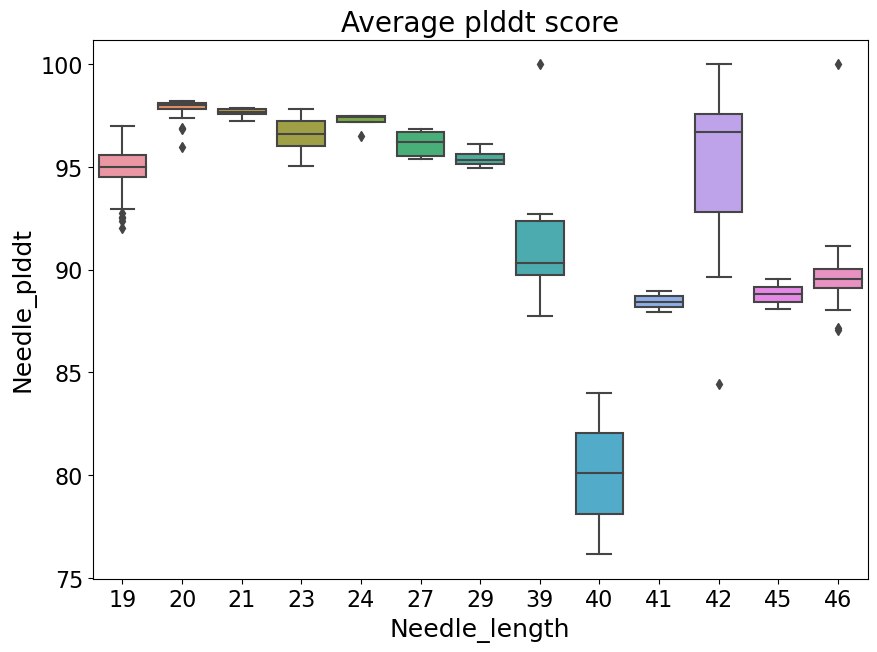

In [8]:
plt.figure(figsize=[10,7])
sns.boxplot(data=new_df, x="Needle_length", y="Needle_plddt")
plt.title("Average plddt score")
plt.show()

In [13]:
## Get IDs with Needle plddt under 70

new_df.loc[new_df["Needle_plddt"] < 80]

,ID,Needle,Needle_length,Needle_start,Needle_stop,Needle_plddt
17,2515271184,YEWQFNGVNNYAKRGGGGPAGGGMPQQATVASLTDDQIRVS,40,230,270,76.152308
